
# DATA301 - Lab 0
## Spark Tutorial (first part)

In this tutorial, you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

Adapted with permission for use in DATA301. Additional credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL and [Michele Catasta](https://www.linkedin.com/in/pirroh/) from Stanford's CS246.

*Note: do not change the existing asserts otherwise you will not know if your code works for our tests. You are welcome to add your own asserts in new cells.*

## Setup

We need to install software on the remote Colab environment. These two lines install Java (required for the backend Spark server) and the PySpark library.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.9 MB/s eta 0:00:00


Run the cell below to download data from google drive to the remote Colab environment

In [2]:
import urllib.request
url = 'https://drive.google.com/uc?export=download&confirm=t&id=1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
filename = 'Bombing_Operations.json.gz'
urllib.request.urlretrieve(url, filename)

('Bombing_Operations.json.gz', <http.client.HTTPMessage at 0x7f47dc1f8400>)

If you executed the cells above correctly, you should be able to see the files *Bombing_Operations.json.gz* under the "Files" tab on the left panel.

### Start the Spark context
Let's start the Spark context on the remote environment. After executing the cell below, an in memory process that handles Spark API calls is running and worker processes are ready to execute RDD operations on the big data set.

In [3]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
spark = SparkSession.builder.master("local[*]").appName('SparkExample').config(
    "spark.executor.memory", "1g").config(
        "spark.executorEnv.PYTHONHASHSEED","0").config("spark.ui.port", "4050"
        ).getOrCreate()
sc = spark.sparkContext

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [4]:
spark

## Warm up exercises (complete the <FILL IN> parts)
These exercises don't use a dataset. Instead they create simple RDD structures from small arrays.

Let us first create a small array that we will manipulate. For realistic applications, data will most likely be loaded from a file or from a data stream. The builtin python command range creates a sequence from 1 to n. Since we generated this data instead of loading it in a distributed fashion, we need to create an RDD. See https://spark.apache.org/docs/latest/rdd-programming-guide.html#resilient-distributed-datasets-rdds for more details.


In [5]:

# First lets create some simple data, say the integers from 1 to 1000. We use the python command range to do this. Note that in practice our data will most likely come from data files. 
A = range(1000)

# Let us start with a simple task of computing the sum of the values in the array:
print(sum(A))
# Because A is in memory in our Google Colab python instance and sum is a built in python function
# this computation is not distributed and instead runs sequentially.

# Now let us distribute this data across all our processes using the sc.parallelize function.
pA = sc.parallelize(A) 

# To sum our distributed array, we call the reduce function with a lambda function that adds two values. 
print(pA.reduce(lambda a,b: a+b))
# Because the data structure pA was distributed across the available processes, the computation for reduction was also distributed.



499500
499500


###Problem 1 (5 points) 
Now that we have seen a simple example, write **sequential** code that implements the example from the lecture

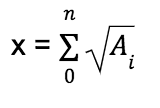

In [6]:
from math import sqrt
def sum_sqrts(A):
  """Sequential code that implements the given formula with an iterative option"""
  accum = sqrt(A[0])
  for index in range(1, len(A)):
      accum += sqrt(A[index])
  return accum

assert sum_sqrts([1,4,9,16]) == 10

In [7]:
assert sum_sqrts([1,4,9,16]) == 10

### Problem 2 (5 points)
Now write a *parallel* version of the code using Spark. You will need to use both map and reduce (see https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-operations).


In [8]:
#note: pA is assumed to be an RDD already, see test case
from math import sqrt
def sum_sqrts_parallel(pA):
    items = pA.map(lambda x : sqrt(x))
    accum = items.reduce(lambda x, y: x+y)
    return accum

assert sum_sqrts_parallel(sc.parallelize([1,4,9,16])) == 10

In [9]:
assert sum_sqrts_parallel(sc.parallelize([1,4,9,16])) == 10

### Problem 3 (15 points)

In [44]:
# Let us quickly review some basic transformations available within Spark. 

# Lets create a small list of numbers to play with. 
nums = sc.parallelize([1,2,3,4,5]) 

# retain elements passing a predicate 
evens = nums.filter(lambda x: x % 2 == 0) 

# map each element to zero or more others 
x = nums.flatMap(lambda x: range(x)) 

# retrieve RDD contents as a local collection 
print(x.collect())

# return first 2 elements
print(evens.take(2))

# count number of elements 
print(nums.count())


[0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]
[2, 4]
5


In the code box below, generate an array of 5 random numbers between 1 and 6 and parallelize it. Write a function that consumes an RDD of numeric values and produces an RDD with that many copies of each value. [note: your code should not collect the RDD into a local data structure]. Some test cases:
```
print(repeat_nums(sc.parallelize([1, 3, 4, 2, 1])).collect())
> [1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]

print(repeat_nums(sc.parallelize([5, 2, 6, 3, 1])).collect())
> [5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]
```
Hint: In python we can repeat using the overloaded multiplier on lists

```
>>> [5] * 4
[5, 5, 5, 5]
```




In [11]:
def repeat_nums(nums):
    copy_nums = nums.flatMap(lambda x: [x] * x)
    return copy_nums

In [12]:
print(repeat_nums(sc.parallelize([1, 3, 4, 2, 1])).collect())
print(repeat_nums(sc.parallelize([5, 2, 6, 3, 1])).collect())

[1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]
[5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]


In [13]:
assert repeat_nums(sc.parallelize([1, 3, 4, 2, 1])).collect() == [1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]
assert repeat_nums(sc.parallelize([5, 2, 6, 3, 1])).collect() == [5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]

## Dataset exercises: The Vietnam War

For the following exercises you will write parallel code in PySpark to extract some data from a small dataset of historical data from the Vietname War.

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operations during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

###*Load the dataset*

In [14]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz").rdd

Get a sample with `take()`:

In [15]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

Note that each RDD entry is a Row object. See https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Row.html for a description on how to access columns using the python properties. Here is a simple example:



In [16]:
Bombing_Operations.first().AirCraft

'EC-47'

### Problem 4 (15 points): How many missions did the UNITED STATES OF AMERICA fly?

In each of these problems you will need to use RDD transformations and actions. You do not need to write full python functions, a lambda expression in each of the <FILL IN> blanks is sufficient. See https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations for a list of available RDD transformations and actions and what they expect.

From the Bombing_Operations RDD count how many rows have ContryFlyingMission with the UNITED STATES OF AMERICA

In [17]:
rdd_filtered = Bombing_Operations.filter(
    lambda x: x[1] == 'UNITED STATES OF AMERICA'
    )
print(rdd_filtered.count())
# should output 3708997

3708997


In [18]:
assert rdd_filtered.count() == 3708997

### Problem 5 (15 points): Show the unique countries targetted in missions on 1972-12-26

In [19]:
dec26 = Bombing_Operations.filter(
    lambda x: x[2] == '1972-12-26'
    )
target_countries = dec26.map(
    lambda x: x[6]
    )
print(target_countries.distinct().collect())
# should output ['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']


['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']


In [20]:
assert target_countries.distinct().collect() == ['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']

### Problem 6 (15 points): Who bombed this location?


<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/Hanoi_POL1966.jpg">

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation. 

We are interested in discovering what was the most common take-off location during that day.

In [21]:
jun_29_operations = Bombing_Operations.filter(
    (lambda x: x[2] == '1966-06-29' and x[6]=='NORTH VIETNAM')
    )

by_takeofflocation_key_values = jun_29_operations.map(
    lambda x: (x[5], 1)
    )

by_takeofflocation = by_takeofflocation_key_values.reduceByKey(
    lambda x, y : x+y
    )

print(by_takeofflocation.collect())

# should produce a (key, value) list of the most common take-off locations with ('CONSTELLATION', 87) as the most common

[('TAKHLI', 56), ('DANANG', 35), ('CONSTELLATION', 87), ('UBON AB', 44), ('UDORN AB', 44), ('KORAT', 55), ('RANGER', 35), ('HANCOCK (CVA-19)', 10), ('TAN SON NHUT', 26), ('CUBI PT', 1), ('CAM RANH BAY', 2)]


In [22]:
assert by_takeofflocation.collect() == [('TAKHLI', 56), ('DANANG', 35), ('CONSTELLATION', 87), ('UBON AB', 44), ('UDORN AB', 44), ('KORAT', 55), ('RANGER', 35), ('HANCOCK (CVA-19)', 10), ('TAN SON NHUT', 26), ('CUBI PT', 1), ('CAM RANH BAY', 2)]

<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

### Problem 7 (20 points): What is the most used aircraft during the Vietnam war (number of missions)?

In this question you must write your own code "from scratch". Hint: if you follow a similar process to problem 6 you can then use the takeOrdered action to get the most used aircraft. To get descending order you'll need to use a custom key expression to order by the negative count.

In [42]:
num_of_aircraft_key_values = Bombing_Operations.map(
    lambda x: (x[0], 1)
    )

missions_collect = num_of_aircraft_key_values.reduceByKey(
    lambda x, y : x+y
    )

most_used = missions_collect.takeOrdered(
    1, key = lambda x: -x[1]
    )

print(most_used)

# should compute [('F-4', 909362)] as the result and assign it to the most_used variable

[('F-4', 909362)]


In [43]:
assert most_used == [('F-4', 909362)]

## Submission
You should go to File->Download->Download .ipynb and then upload that file to the last question in the Learn assessment.